# Actividad 9 - Boosting Classifiers

### Desafío 1: Preprocesamiento
- Grafique el comportamiento distributivo de los atributos y de la variable dependiente. Reporte brevemente el comportamiento de las variables.
- En base al comportamiento de los atributos, considere si es necesario implementar alguna recodificación o transformación de atributo. Algunas normas a seguir:
  - Para las variables categóricas, recodifíquelas en variables binarias.
  - Para aquellas variables numéricas que presenten alto sesgo, pueden transformarlas con su logaritmo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seed = 602

In [2]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [3]:
df_train = pd.read_csv('churn_train.csv').drop(columns='Unnamed: 0')
df_test = pd.read_csv('churn_test.csv').drop(columns='Unnamed: 0')


X_train = df_train.drop(columns='churn')
y_train = np.where(df_train['churn'] == 'yes', 1, 0)

X_test  = df_test.drop(columns='churn')
y_test  = np.where(df_test['churn'] == 'yes', 1, 0)

In [4]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


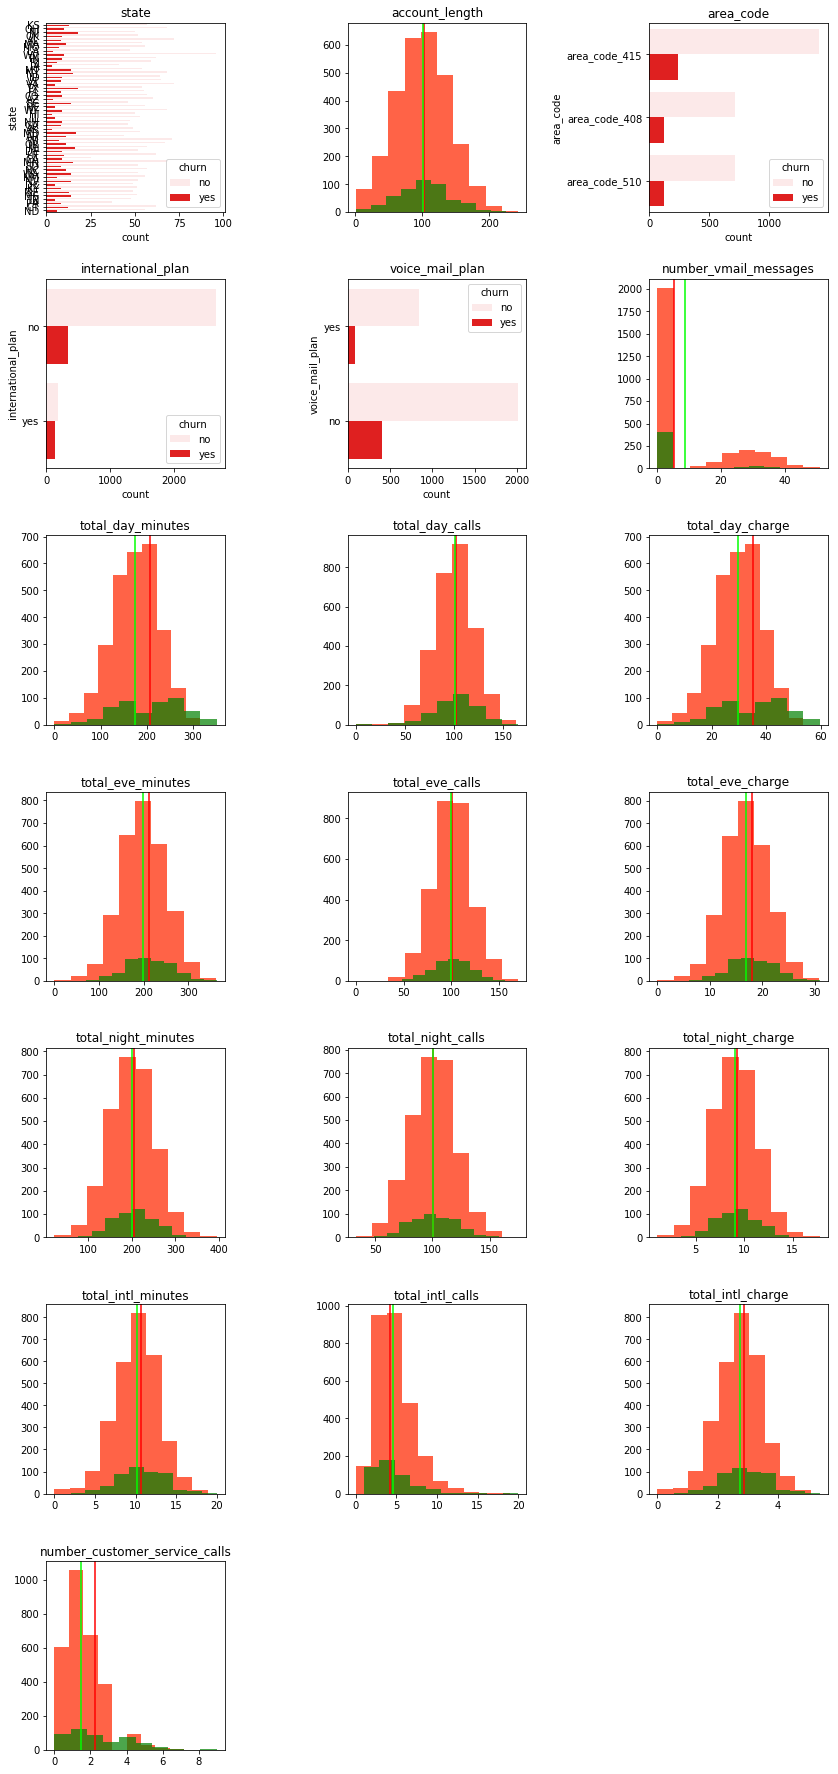

In [5]:
plt.figure(figsize=(12,25))
for i, (colname, serie) in enumerate(X_train.iteritems()):
    plt.subplot(7,3,i+1)
    plt.title(colname)
    if(serie.dtype == 'object'):
        sns.countplot(y=serie, hue='churn', data=df_train, color="red")
    else:
        plt.hist(df_train[df_train['churn'] == 'no'][colname], color="tomato")
        plt.axvline(np.mean(df_train[df_train['churn'] == 'yes'][colname]), color='red')

        plt.hist(df_train[df_train['churn'] == 'yes'][colname], color="green", alpha=0.7)
        plt.axvline(np.mean(df_train[df_train['churn'] == 'no'][colname]), color='lime')
plt.tight_layout(pad=2)
    
    

- Revisando los gráficos tranformaremos la variable `number_vmail_messages`
- También recodificamos las variables categóricas

In [6]:
X_train['number_vmail_messages'] = np.log(X_train['number_vmail_messages']+0.01)
X_test['number_vmail_messages'] = np.log(X_test['number_vmail_messages']+0.01)

In [7]:
for colname, serie in X_train.iteritems():    
    if(serie.dtype == 'object' and colname != 'churn'):
        X_train = pd.concat([X_train, pd.get_dummies(serie, drop_first=True, prefix=colname)], axis=1).drop(columns=colname)

for colname, serie in X_test.iteritems():    
    if(serie.dtype == 'object' and colname != 'churn'):
        X_test = pd.concat([X_test, pd.get_dummies(serie, drop_first=True, prefix=colname)], axis=1).drop(columns=colname)

### Desafío 2: Comparación de AdaBoost y Gradient Boosting
- Entrene los clasificadores AdaBoost y Gradient Boosting para mejorar su capacidad predictiva en la medida de lo posible. Para ello, implemente una búsqueda de grilla con las siguientes especificaciones:
- Si el tiempo de computación es alto, puede implementar la búsqueda con 1 validación cruzada.
- Reporte las métricas para los mejores modelos.

In [8]:
ada_param = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 500, 1000, 2000]}
gr_param = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000,2000], 'subsample': [0.1,0.5,0.9]}

In [9]:
%%time
model_ada = GridSearchCV(AdaBoostClassifier(random_state=seed), ada_param, cv=3)
model_ada.fit(X_train, y_train)

CPU times: user 2min 58s, sys: 1.42 s, total: 3min
Wall time: 3min 5s


In [10]:
adaboost_y_hat = model_ada.predict(X_test)
print(classification_report(y_test, adaboost_y_hat, digits=3))

              precision    recall  f1-score   support

           0      0.901     0.977     0.938      1443
           1      0.676     0.308     0.423       224

   micro avg      0.887     0.887     0.887      1667
   macro avg      0.789     0.643     0.680      1667
weighted avg      0.871     0.887     0.868      1667



In [11]:
%%time
model_gr = GridSearchCV(GradientBoostingClassifier(random_state=seed), gr_param, cv=3)
model_gr.fit(X_train, y_train)

CPU times: user 7min 56s, sys: 2.56 s, total: 7min 58s
Wall time: 8min 8s


In [12]:
grboost_y_hat = model_gr.predict(X_test)
print(classification_report(y_test, grboost_y_hat, digits=3))

              precision    recall  f1-score   support

           0      0.956     0.992     0.973      1443
           1      0.929     0.705     0.802       224

   micro avg      0.953     0.953     0.953      1667
   macro avg      0.943     0.849     0.888      1667
weighted avg      0.952     0.953     0.950      1667



- El modelo de Grandien Boosting se comporta mejor que el de Ada Boosting en todas las métricas.

### Desafío 4: Principales factores asociados
- Con el mejor modelo, reporte la importancia relativa de los atributos y comente cuáles son los que aumentan la probabilidad de fuga en los clientes.

- tip: Pueden implementar la función plot_importance que se encuentra en la lectura de Bagging y Random Forest.


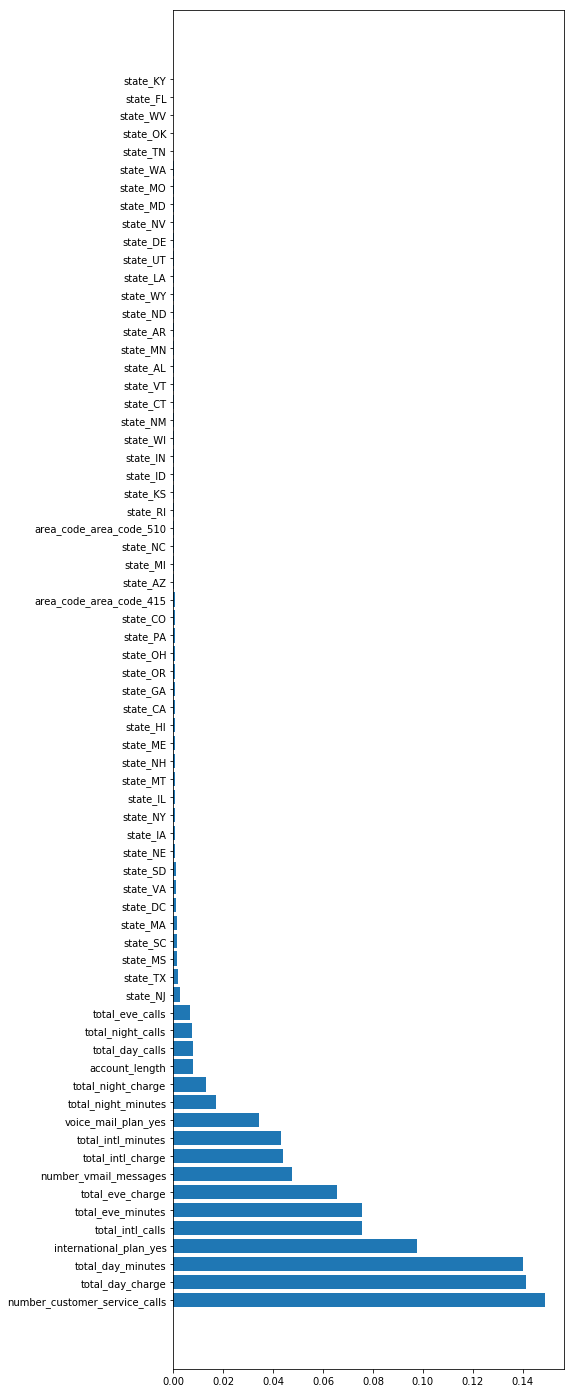

In [13]:
plt.figure(figsize = (7,25))

feat_names = X_test.columns

tmp_importance = model_gr.best_estimator_.feature_importances_
    # sort features
sort_importance = np.argsort(tmp_importance)[::-1]
    # associate feat_names with its relative importance
names = [feat_names[i] for i in sort_importance]
    # plot
plt.barh( range(len(feat_names)), tmp_importance[sort_importance])
    # add axis labels identifying attribute name
plt.yticks(range(len(feat_names)), 
               names, rotation=0);

Los atributos que más explican la fuga de clientes es:
- Los cobros de la mañana
- number_customer_service_calls
- Total de Minutos mañana
- Planes internacionales

### Desafío 5: Probabilidad de fuga
- El gerente general necesita saber en qué estados hay una mayor probabilidad de fuga de clientes. Para ello, identifique los tres estados con una mayor probabilidad de fuga.
- Implemente el modelo predictivo con el archivo churn_test.csv .
- Recuerde que para obtener la probabilidad de clase, debe utilizar la función predict_proba del modelo.

In [14]:
prob_fuga =model_gr.best_estimator_.predict_proba(X_test) 

In [15]:
df_test['proba'] = pd.Series(prob_fuga[:, 1])

In [16]:
states_pr = df_test.groupby(by='state').mean()

In [17]:
states_pr.sort_values(by='proba', ascending=False).head(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,proba
state,,,,,,,,,,,,,,,,
NJ,106.204545,4.000000,185.690909,102.886364,31.567500,193.756818,96.795455,16.468864,200.988636,103.204545,9.045227,10.393182,4.363636,2.806818,1.818182,0.280094
OK,95.103448,2.241379,199.896552,101.413793,33.982759,210.493103,101.448276,17.892759,197.651724,95.620690,8.894138,10.655172,4.344828,2.877586,1.551724,0.249035
CA,102.944444,1.222222,152.850000,98.833333,25.985556,186.438889,97.500000,15.847222,202.144444,90.222222,9.096667,10.177778,4.166667,2.747778,1.666667,0.216739
MT,100.870968,6.000000,186.812903,100.258065,31.757419,210.012903,96.161290,17.851290,194.122581,100.354839,8.735484,10.451613,4.612903,2.821935,1.419355,0.206846
KS,96.655172,8.482759,192.658621,97.862069,32.751379,220.668966,102.965517,18.757241,195.720690,103.896552,8.808276,11.089655,4.206897,2.994138,1.620690,0.200406


- Predecimos la probabilidad de fuga para la base de test
- Luego agregamos la probabilidad de fuga a nuestro DataFrame, para luego agrupar por estado
- Según el promedio, los estados con mayor probabilidad de fua son New Jersey, Oklahoma, California, Montana y Kansas